In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime
from dateutil import parser
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from scipy.spatial.distance import cdist, pdist
from shapely.geometry import Point
from matplotlib.pylab import plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
# get US states shapefile
state = gpd.read_file('Data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
state.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [8]:
state = state[~state.STATEFP.isin(['02','15','60','66','69','72','78'])] # remove Alaska, Hawaii and US Territories

<AxesSubplot:>

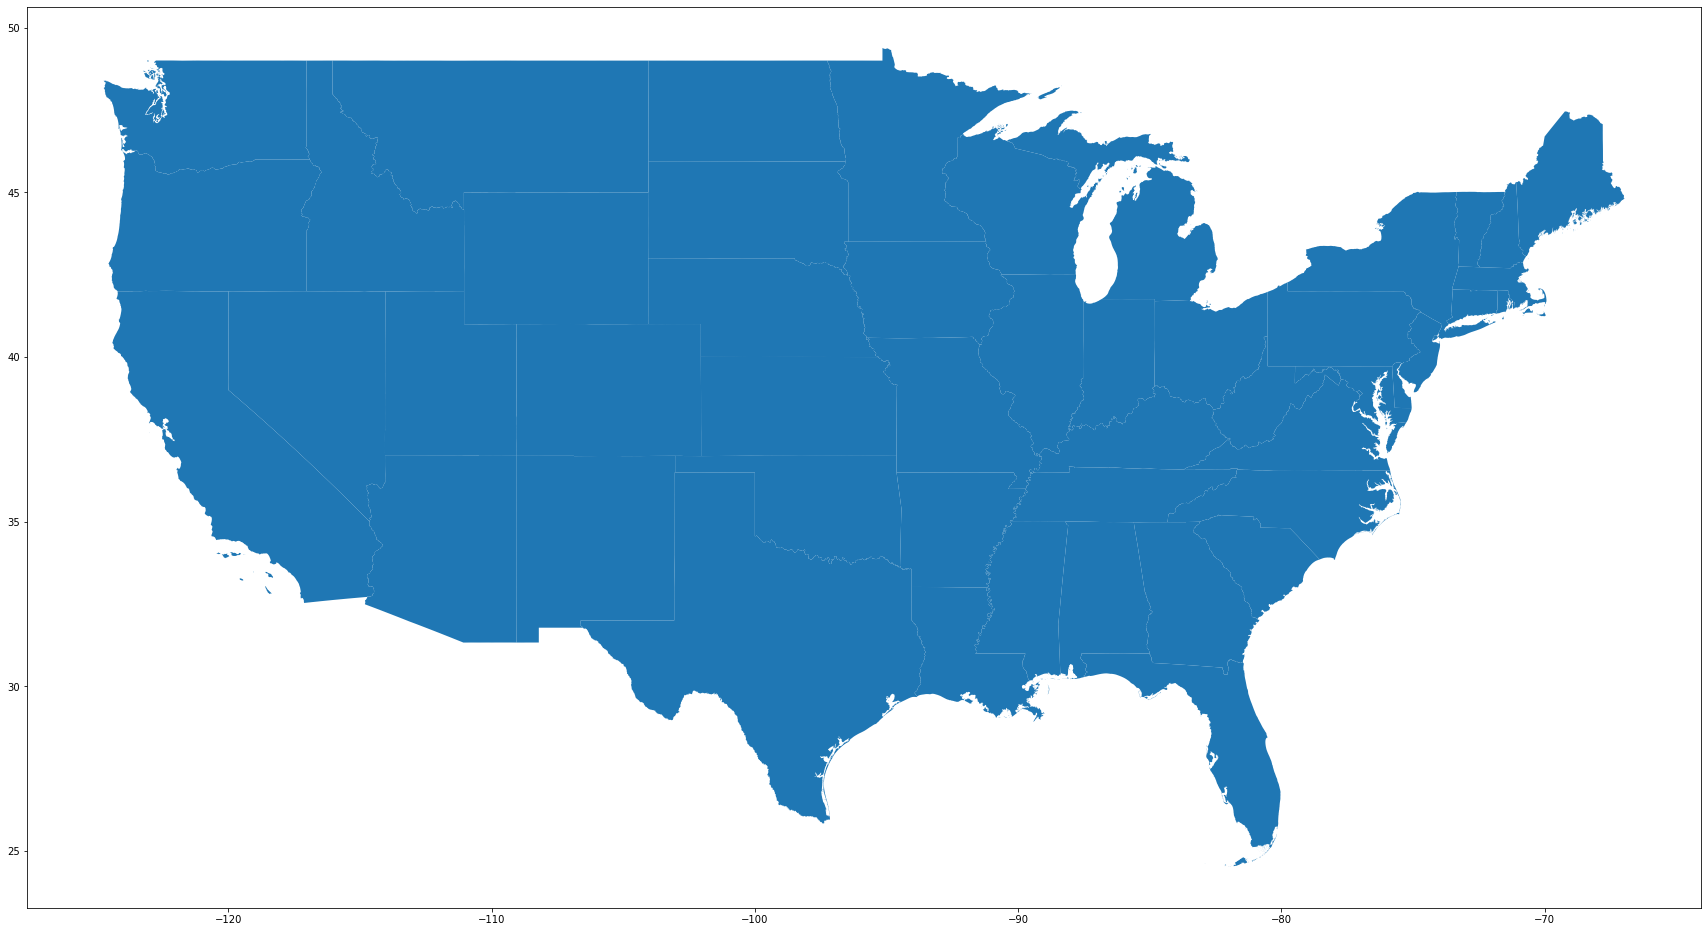

In [9]:
state.plot(figsize=(30,30))

In [45]:
energy1 = pd.read_csv('Data/epa_yearly_till_2010.csv')
energy1.head()

,Plant ID,Combined Heat & Power Plant,Nuclear Unit I.D.,Plant Name,Operator Name,Operator ID,State,Census Region,NERC Region,Reserved,...,NETGEN_SEP,NETGEN_OCT,NETGEN_NOV,NETGEN_DEC,TOTAL FUEL CONSUMPTION QUANTITY,ELECTRIC FUEL CONSUMPTION QUANTITY,TOTAL FUEL CONSUMPTION MMBTUS,ELEC FUEL CONSUMPTION MMBTUS,NET GENERATION (megawatthours),Year
0,2,N,NaN,Bankhead Dam,Alabama Power Co,195.0,AL,ESC,SERC,NaN,...,17519.0,14197.0,12264.0,32459.0,0.0,0.0,2.428121e+06,2.428121e+06,234987.0,2001
1,3,N,NaN,Barry,Alabama Power Co,195.0,AL,ESC,SERC,NaN,...,1001041.0,1072678.0,811651.0,641360.0,4358193.0,4358193.0,1.035403e+08,1.035403e+08,10559116.0,2001
2,3,N,NaN,Barry,Alabama Power Co,195.0,AL,ESC,SERC,NaN,...,0.0,25.0,12.0,0.0,383.0,383.0,2.236000e+03,2.236000e+03,244.0,2001
3,3,N,NaN,Barry,Alabama Power Co,195.0,AL,ESC,SERC,NaN,...,551090.0,574136.0,685933.0,452208.0,37069993.0,37069993.0,3.863433e+07,3.863433e+07,5239405.0,2001
4,4,N,NaN,Walter Bouldin Dam,Alabama Power Co,195.0,AL,ESC,SERC,NaN,...,32789.0,13045.0,19684.0,62390.0,0.0,0.0,6.083161e+06,6.083161e+06,588712.0,2001


In [46]:
energy2 = pd.read_csv('Data/epa_yearly_post_2011.csv')
energy2.head()

,Plant Id,Combined Heat And\nPower Plant,Nuclear Unit Id,Plant Name,Operator Name,Operator Id,Plant State,Census Region,NERC Region,Reserved,...,Netgen_Oct,Netgen_Nov,Netgen_Dec,Total Fuel Consumption Quantity,Electric Fuel Consumption Quantity,Total Fuel Consumption MMBtu,Elec Fuel Consumption MMBtu,Net Generation (Megawatthours),Balancing\nAuthority Code,Respondent\nFrequency
0,2,N,NaN,Bankhead Dam,Alabama Power Co,195,AL,ESC,SERC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,N,NaN,Barry,Alabama Power Co,195,AL,ESC,SERC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,N,NaN,Barry,Alabama Power Co,195,AL,ESC,SERC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,N,NaN,Barry,Alabama Power Co,195,AL,ESC,SERC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,N,NaN,Barry,Alabama Power Co,195,AL,ESC,SERC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data cleaning.

In [47]:
energy3 = energy2[energy2.YEAR==2011]

In [48]:
energy1 = energy1[['Operator Name','State','NET GENERATION (megawatthours)','AER Fuel Type Code','Year']]
energy2 = energy2[['Operator Name','Plant State','AER\nFuel Type Code','Net Generation\n(Megawatthours)','YEAR']]
energy3 = energy3[['Operator Name','State','AER Fuel Type Code','Net Generation (Megawatthours)','YEAR']]

In [49]:
energy_dict = {'Operator Name':'Operator','Plant State':'State','NET GENERATION (megawatthours)':'MegaWatt','Net Generation (Megawatthours)':'MegaWatt','Net Generation\n(Megawatthours)':'MegaWatt','AER Fuel Type Code':'Fuel','AER\nFuel Type Code':'Fuel','YEAR':'Year'}
energy1 = energy1.rename(columns=energy_dict)
energy2 = energy2.rename(columns=energy_dict)
energy3 = energy3.rename(columns=energy_dict)
energy1['Year'] = energy1['Year'].astype(str)
energy2['Year'] = energy2['Year'].astype(str)
energy3['Year'] = energy3['Year'].astype(str)

In [52]:
energy2 = energy2[energy2.Year!='.']
energy2 = energy2[energy2.Year!='2011']

In [55]:
# add all data into one
energy = pd.concat([energy1,energy3,energy2], join='inner', ignore_index=True)

In [56]:
# replace code names with the actual name of fuel type
fuel_dict = {'HYC':'Hydroelectric','COL':'Coal','DFO':'Petroleum','NG':'Natural Gas','NUC':'Nuclear','RFO':'Petroleum','MLG':'Other Renewable','PC':'Petroleum','SUN':'Solar','HPS':'Hydroelectric','GEO':'Other Renewable','ORW':'Other Renewable','OTH':'Other Renewable','WOO':'Other Non-Renewable','WWW':'Other Non-Renewable','WND':'Wind','OOG':'Other Non-Renewable','WOC':'Coal'}
energy = energy.replace({'Fuel':fuel_dict}).dropna()

In [26]:
# each fuel type with their respective hex color code
color_dict = {'Hydroelectric':'#1a8cff','Coal':'#C0C0C0','Petroleum':'#5c3d1f','Natural Gas':'#666699','Nuclear':'#c571da','Other Non-Renewable':'#9966ff','Other Renewable':'#32CD32','Solar':'#FFD700','Wind':'#20B2AA'}

In [57]:
# all fuel types and the amount of power generated from each of them in the US, temporally
df = energy[['Year','Fuel','MegaWatt']].groupby(['Year','Fuel']).sum()
df = pd.pivot_table(df,index='Year',columns='Fuel',values='MegaWatt',fill_value=0)
df

Fuel,Coal,Hydroelectric,Natural Gas,Nuclear,Other Non-Renewable,Other Renewable,Petroleum,Solar,Wind
Year,,,,,,,,,
2001,1.903917e+09,2.081034e+08,6.391288e+08,7.688263e+08,4.453082e+07,4.016170e+07,1.245220e+08,5.427550e+05,6.663553e+06
2002,1.933130e+09,2.555694e+08,6.910057e+08,7.800641e+08,5.119492e+07,4.306193e+07,9.348148e+07,5.548311e+05,1.035428e+07
2003,1.973737e+09,2.672713e+08,6.499075e+08,7.637327e+08,5.475471e+07,4.426644e+07,1.177800e+08,5.340014e+05,1.118747e+07
2004,1.978301e+09,2.599291e+08,7.101000e+08,7.885284e+08,5.506061e+07,4.446395e+07,1.194538e+08,5.751550e+05,1.414374e+07
2005,2.012873e+09,2.637635e+08,7.609603e+08,7.819864e+08,5.408341e+07,4.293320e+07,1.204622e+08,5.502943e+05,1.781055e+07
2006,1.990511e+09,2.826886e+08,8.164408e+08,7.872186e+08,5.430061e+07,4.364095e+07,6.280471e+07,5.077060e+05,2.658914e+07
2007,2.016456e+09,2.406136e+08,8.965898e+08,8.064248e+08,5.424015e+07,4.339290e+07,6.396620e+07,6.117930e+05,3.444993e+07
2008,1.985801e+09,2.485433e+08,8.829806e+08,8.062084e+08,5.069948e+07,4.437740e+07,4.454986e+07,8.643148e+05,5.536310e+07
2009,1.755904e+09,2.688177e+08,9.209787e+08,7.988546e+08,4.808346e+07,4.537959e+07,3.753530e+07,8.911794e+05,7.388613e+07


In [20]:
#df.to_excel('energy_table.xlsx')

In [59]:
# focus on four separate years: 2005, 2010, 2015, 2020. Exclude Hawaii and Alaska.
energy2005 = energy[(energy.Year=='2005') & (energy.State!='HI') & (energy.State!='AK')]
energy2010 = energy[(energy.Year=='2010') & (energy.State!='HI') & (energy.State!='AK')]
energy2015 = energy[(energy.Year=='2015') & (energy.State!='HI') & (energy.State!='AK')]
energy2020 = energy[(energy.Year=='2020') & (energy.State!='HI') & (energy.State!='AK')]

In [60]:
# get fuel type and their power generated in each state from those four years.
state2005 = energy2005[['State','Fuel','MegaWatt']].groupby(['State','Fuel']).sum()
state2010 = energy2010[['State','Fuel','MegaWatt']].groupby(['State','Fuel']).sum()
state2015 = energy2015[['State','Fuel','MegaWatt']].groupby(['State','Fuel']).sum()
state2020 = energy2020[['State','Fuel','MegaWatt']].groupby(['State','Fuel']).sum()

In [61]:
#convert a list to a 2d table with states as rows and the various renewable and non-renewable fuel types as columns
state2005 = pd.pivot_table(state2005,index='State',columns='Fuel',values='MegaWatt',fill_value=0)
state2010 = pd.pivot_table(state2010,index='State',columns='Fuel',values='MegaWatt',fill_value=0)
state2015 = pd.pivot_table(state2015,index='State',columns='Fuel',values='MegaWatt',fill_value=0)
state2020 = pd.pivot_table(state2020,index='State',columns='Fuel',values='MegaWatt',fill_value=0)

In [63]:
# normalize the fuel types within each state by their total energy output to get size-independent fuel type profiles
norm2005 = state2005.div(state2005.sum(axis=1), axis=0).dropna()
norm2010 = state2010.div(state2010.sum(axis=1), axis=0).dropna()
norm2015 = state2015.div(state2015.sum(axis=1), axis=0).dropna()
norm2020 = state2020.div(state2020.sum(axis=1), axis=0).dropna()

In [64]:
norm2005.head()

Fuel,Coal,Hydroelectric,Natural Gas,Nuclear,Other Non-Renewable,Other Renewable,Petroleum,Solar,Wind
State,,,,,,,,,
AL,0.566359,0.073539,0.100541,0.229754,0.027320,0.000301,0.002186,0.000000,0.000000
AR,0.482004,0.064928,0.125656,0.286426,0.035905,0.000899,0.004182,0.000000,0.000000
AZ,0.395586,0.064225,0.284720,0.254314,0.000119,0.000477,0.000426,0.000134,0.000000
CA,0.010661,0.198468,0.466087,0.180510,0.030149,0.078214,0.011952,0.002680,0.021280
CO,0.716899,0.026064,0.240308,0.000000,0.000071,0.000683,0.000331,0.000000,0.015645


In [65]:
#apply clustering to the states based on their fuel profiles
#characterize each cluster by its aggregated fuel profile
#visualize the clustering together with the categorical fuel type profile of each cluster

import matplotlib.cm as cm

def silhouette_score_plot(data,range_n_clusters):
    X=data
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(10, 5)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=324)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)

        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3916465367445812


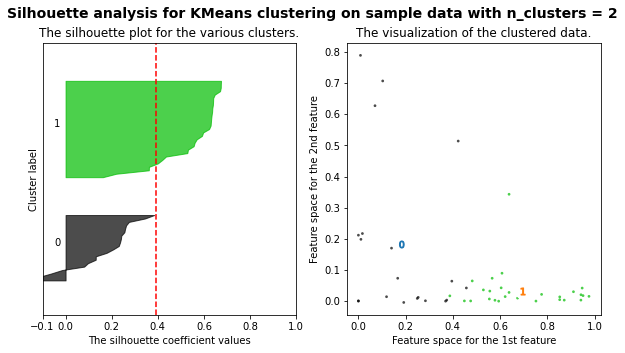

For n_clusters = 3 The average silhouette_score is : 0.42614180869935364


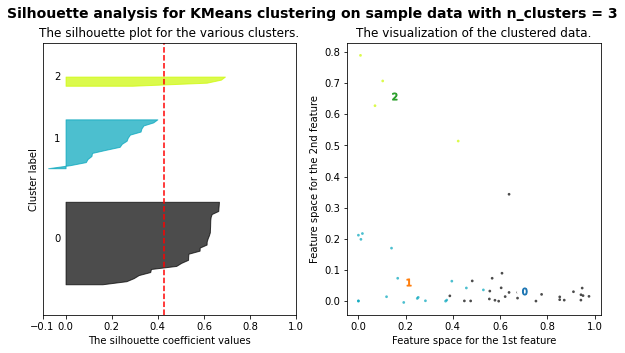

For n_clusters = 4 The average silhouette_score is : 0.43239736097231596


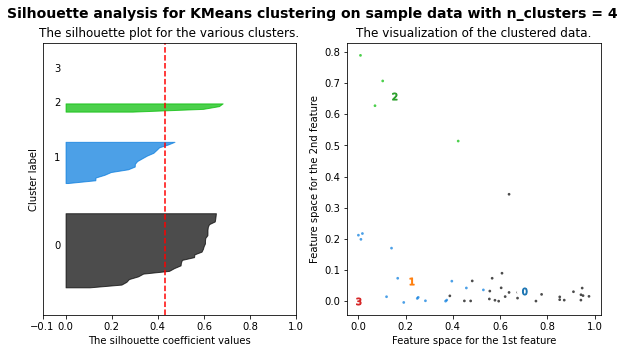

For n_clusters = 5 The average silhouette_score is : 0.3902508219253524


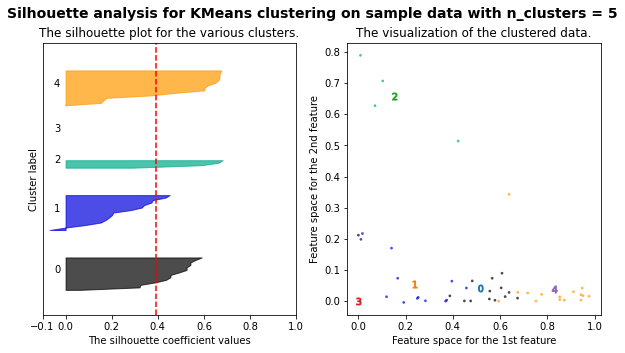

In [137]:
# for year 2005, the silhouette score
silhouette_score_plot(np.asarray(norm2005), range(2,6))

In [66]:
# for year 2010
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(norm2010)
    #report average Silhouette score
    silhouette_avg = silhouette_score(norm2010, cluster_labels)
    print("For n_clusters={},".format(n_clusters)+" the average silhouette_score is: {}".format(silhouette_avg))

For n_clusters=2, the average silhouette_score is: 0.36418568549778857
For n_clusters=3, the average silhouette_score is: 0.41728903617727164
For n_clusters=4, the average silhouette_score is: 0.38829372753443575
For n_clusters=5, the average silhouette_score is: 0.41485676845102454
For n_clusters=6, the average silhouette_score is: 0.4535241198472148
For n_clusters=7, the average silhouette_score is: 0.41706738024361795


In [67]:
# for year 2015
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(norm2015)
    #report average Silhouette score
    silhouette_avg = silhouette_score(norm2015, cluster_labels)
    print("For n_clusters={},".format(n_clusters)+" the average silhouette_score is: {}".format(silhouette_avg))

For n_clusters=2, the average silhouette_score is: 0.348445148641081
For n_clusters=3, the average silhouette_score is: 0.4258573336636248
For n_clusters=4, the average silhouette_score is: 0.4323265878723506
For n_clusters=5, the average silhouette_score is: 0.38084059763183126
For n_clusters=6, the average silhouette_score is: 0.3960121435319207
For n_clusters=7, the average silhouette_score is: 0.3688412835860411


In [68]:
# for year 2020
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(norm2020)
    #report average Silhouette score
    silhouette_avg = silhouette_score(norm2020, cluster_labels)
    print("For n_clusters={},".format(n_clusters)+" the average silhouette_score is: {}".format(silhouette_avg))

For n_clusters=2, the average silhouette_score is: 0.3233980552854025
For n_clusters=3, the average silhouette_score is: 0.40217781506983236
For n_clusters=4, the average silhouette_score is: 0.38989818116914937
For n_clusters=5, the average silhouette_score is: 0.3730114790377512
For n_clusters=6, the average silhouette_score is: 0.37017405866524655
For n_clusters=7, the average silhouette_score is: 0.31847628465472094


In [69]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

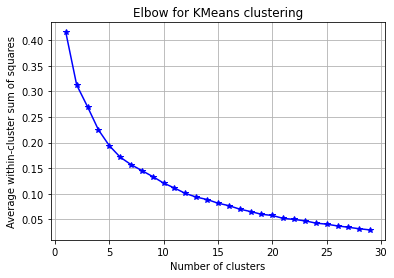

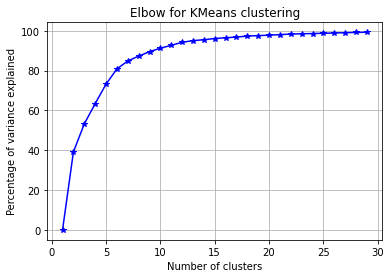

In [70]:
elbow(norm2005, range(1,30))

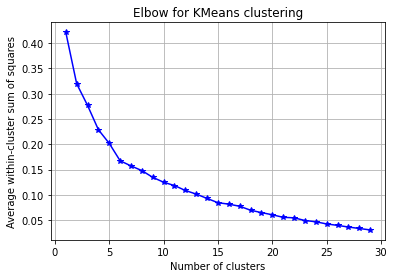

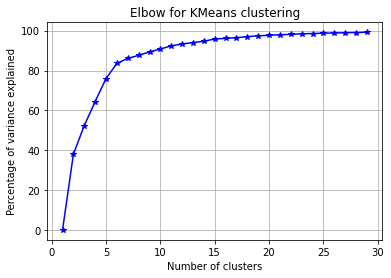

In [71]:
elbow(norm2010, range(1,30))

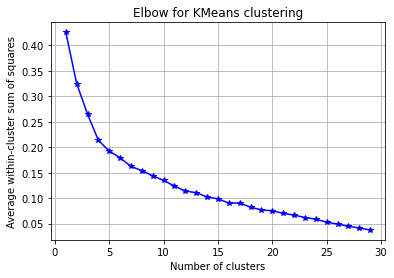

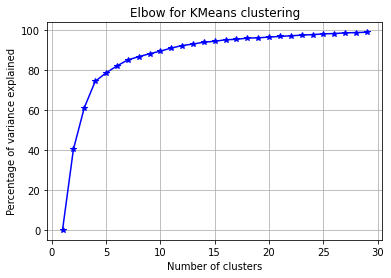

In [72]:
elbow(norm2015, range(1,30))

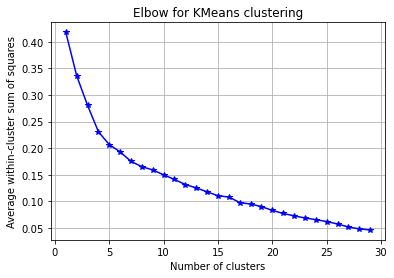

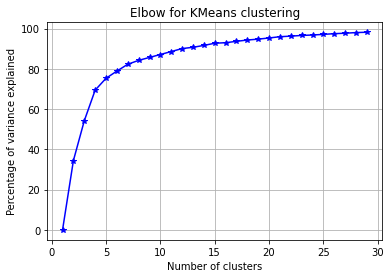

In [73]:
elbow(norm2020, range(1,30))

In [74]:
fuel = list(energy2005.Fuel.unique())
fuel1 = ['Coal','Natural Gas','Petroleum','Other Non-Renewable','Nuclear','Hydroelectric','Solar','Wind','Other Renewable']

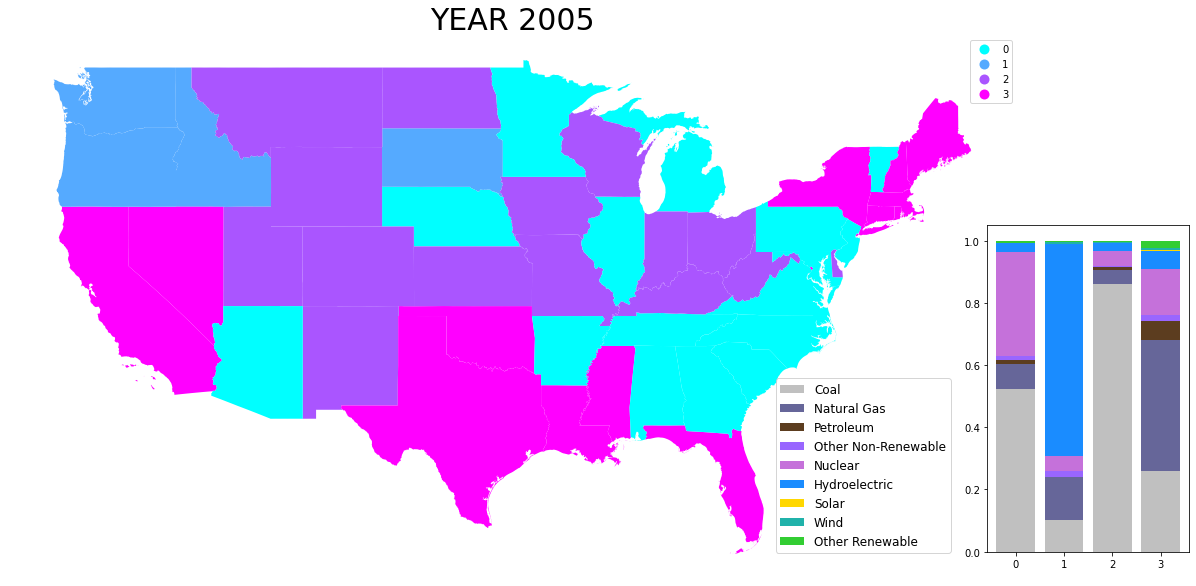

In [75]:
# apply clustering to the states based on their fuel-type profiles
rr = KMeans(n_clusters=4, random_state = 0).fit(norm2005)
rr.labels_ = rr.predict(norm2005)
norm2005['label'] = list(rr.labels_)
norm2005['label'] = norm2005['label'].astype(str)

# characterize each cluster by its aggregated fuel-type profile
# normalize by total cluster activity
state2005['label'] = norm2005['label']
clusterChar = state2005.groupby(['label']).sum().reset_index()
clusterChar = clusterChar[fuel].div(clusterChar[fuel].sum(axis=1), axis=0)
clusterChar = clusterChar[fuel1]

# visualize the clustering together with the categorical fuel-type profile of each cluster
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
state.merge(norm2005,left_on='STUSPS',right_on='State').plot(column='label',cmap='cool',legend=True,ax=ax)
ax.set_title('YEAR 2005',fontsize=30)
ax.axis('off')

ins = ax.inset_axes([.97,0.05,0.2,0.6])
ins.set_prop_cycle(color=['#C0C0C0','#666699','#5c3d1f','#9966ff','#c571da','#1a8cff','#FFD700','#20B2AA','#32CD32'])
bot = np.zeros(4)

for col in clusterChar.columns:
    values = clusterChar[col].values
    ins.bar([0,1,2,3], values, bottom = bot, label=col)
    bot = bot + values
    
ins.set_xticks([0,1,2,3])    
ins.legend(bbox_to_anchor=(-.15,.55),fontsize=12) 

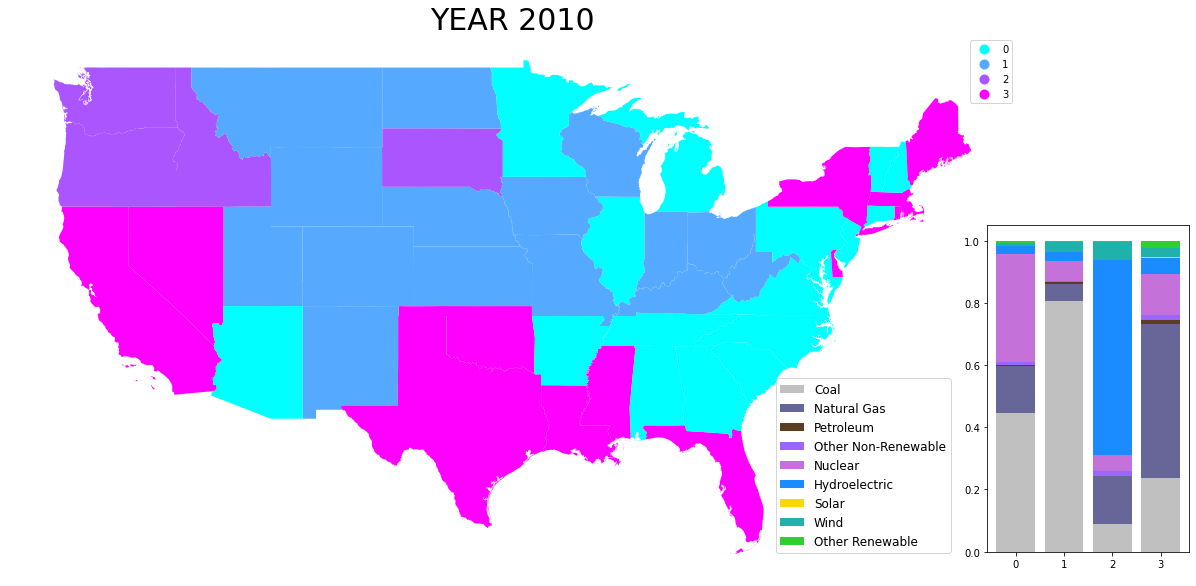

In [76]:
# apply clustering to the states based on their fuel-type profiles
rr = KMeans(n_clusters=4, random_state = 0).fit(norm2010)
rr.labels_ = rr.predict(norm2010)
norm2010['label'] = list(rr.labels_)
norm2010['label'] = norm2010['label'].astype(str)

# characterize each cluster by its aggregated fuel-type profile
# normalize by total cluster activity
state2010['label'] = norm2010['label']
clusterChar = state2010.groupby(['label']).sum().reset_index()
clusterChar = clusterChar[fuel].div(clusterChar[fuel].sum(axis=1), axis=0)
clusterChar = clusterChar[fuel1]

# visualize the clustering together with the categorical fuel-type profile of each cluster
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
state.merge(norm2010,left_on='STUSPS',right_on='State').plot(column='label',cmap='cool',legend=True,ax=ax)
ax.set_title('YEAR 2010',fontsize=30)
ax.axis('off')

ins = ax.inset_axes([.97,0.05,0.2,0.6])
ins.set_prop_cycle(color=['#C0C0C0','#666699','#5c3d1f','#9966ff','#c571da','#1a8cff','#FFD700','#20B2AA','#32CD32'])
bot = np.zeros(4)

for col in clusterChar.columns:
    values = clusterChar[col].values
    ins.bar([0,1,2,3], values, bottom = bot, label=col)
    bot = bot + values
    
ins.set_xticks([0,1,2,3])    
ins.legend(bbox_to_anchor=(-.15,.55),fontsize=12) 

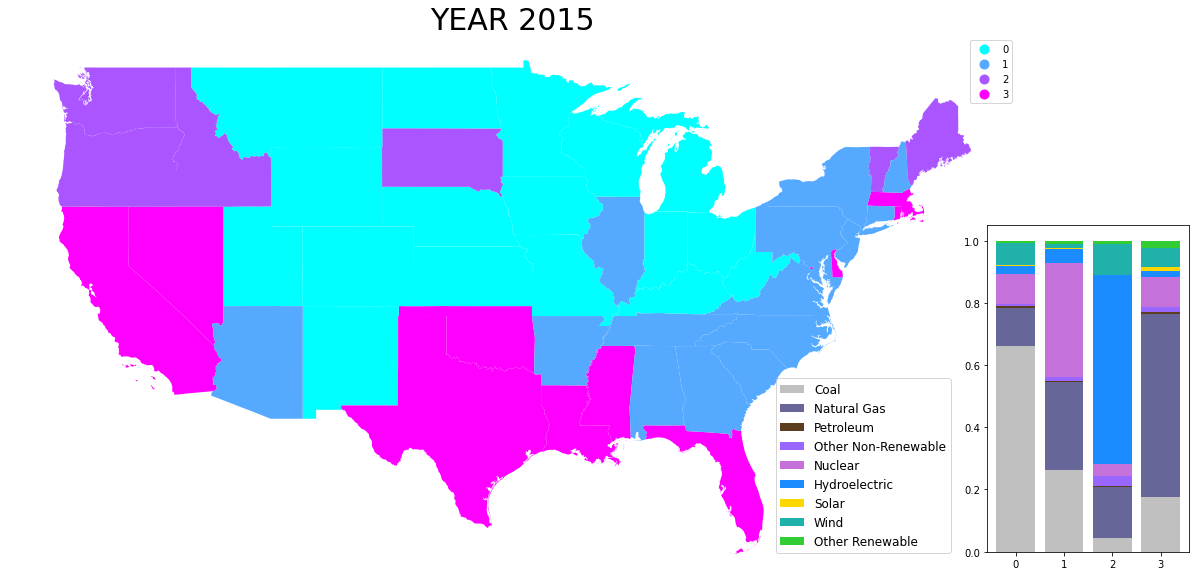

In [77]:
# apply clustering to the states based on their fuel-type profiles
rr = KMeans(n_clusters=4, random_state = 0).fit(norm2015)
rr.labels_ = rr.predict(norm2015)
norm2015['label'] = list(rr.labels_)
norm2015['label'] = norm2015['label'].astype(str)

# characterize each cluster by its aggregated fuel-type profile
# normalize by total cluster activity
state2015['label'] = norm2015['label']
clusterChar = state2015.groupby(['label']).sum().reset_index()
clusterChar = clusterChar[fuel].div(clusterChar[fuel].sum(axis=1), axis=0)
clusterChar = clusterChar[fuel1]

# visualize the clustering together with the categorical fuel-type profile of each cluster
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
state.merge(norm2015,left_on='STUSPS',right_on='State').plot(column='label',cmap='cool',legend=True,ax=ax)
ax.set_title('YEAR 2015',fontsize=30)
ax.axis('off')

ins = ax.inset_axes([.97,0.05,0.2,0.6])
ins.set_prop_cycle(color=['#C0C0C0','#666699','#5c3d1f','#9966ff','#c571da','#1a8cff','#FFD700','#20B2AA','#32CD32'])
bot = np.zeros(4)

for col in clusterChar.columns:
    values = clusterChar[col].values
    ins.bar([0,1,2,3], values, bottom = bot, label=col)
    bot = bot + values
    
ins.set_xticks([0,1,2,3])    
ins.legend(bbox_to_anchor=(-.15,.55),fontsize=12) 

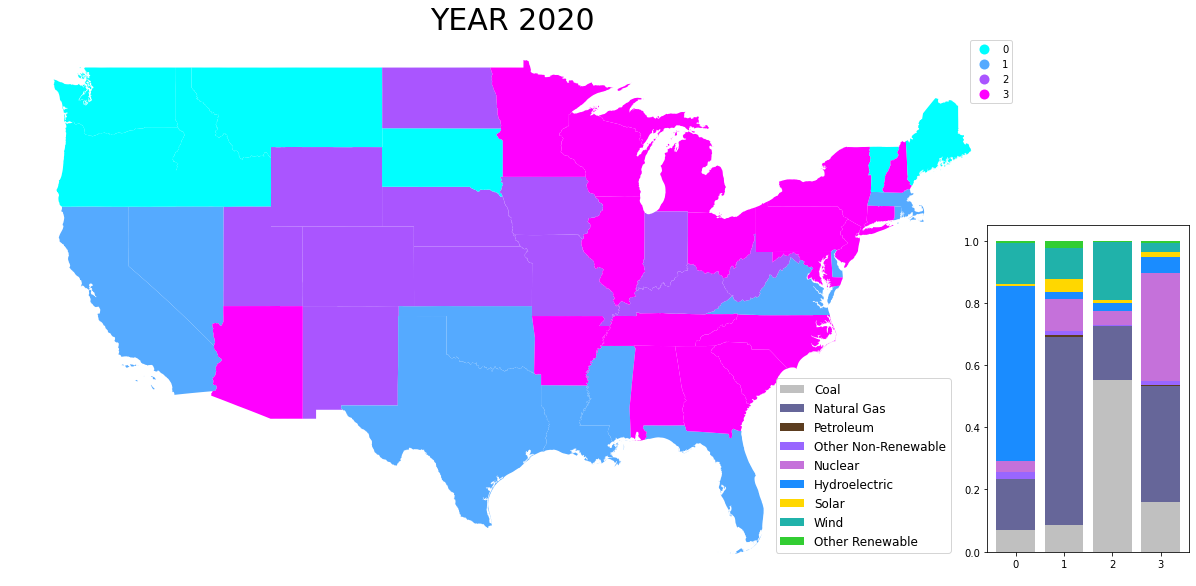

In [78]:
# apply clustering to the states based on their fuel-type profiles
rr = KMeans(n_clusters=4, random_state = 0).fit(norm2020)
rr.labels_ = rr.predict(norm2020)
norm2020['label'] = list(rr.labels_)
norm2020['label'] = norm2020['label'].astype(str)

# characterize each cluster by its aggregated fuel-type profile
# normalize by total cluster activity
state2020['label'] = norm2020['label']
clusterChar = state2020.groupby(['label']).sum().reset_index()
clusterChar = clusterChar[fuel].div(clusterChar[fuel].sum(axis=1), axis=0)
clusterChar = clusterChar[fuel1]

# visualize the clustering together with the categorical fuel-type profile of each cluster
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
state.merge(norm2020,left_on='STUSPS',right_on='State').plot(column='label',cmap='cool',legend=True,ax=ax)
ax.set_title('YEAR 2020',fontsize=30)
ax.axis('off')

ins = ax.inset_axes([.97,0.05,0.2,0.6])
ins.set_prop_cycle(color=['#C0C0C0','#666699','#5c3d1f','#9966ff','#c571da','#1a8cff','#FFD700','#20B2AA','#32CD32'])
bot = np.zeros(4)

for col in clusterChar.columns:
    values = clusterChar[col].values
    ins.bar([0,1,2,3], values, bottom = bot, label=col)
    bot = bot + values
    
ins.set_xticks([0,1,2,3])    
ins.legend(bbox_to_anchor=(-.15,.55),fontsize=12) 

In 2020, power generation in the US came from more renewable sources as shown directly above. For instance, clustering label ‘0’ is made up of mostly hydroelectricity, and now includes not only the Pacific Northwest but states like Montana, Maine, and Vermont. States in purple, generally in the Central regions, have shifted towards wind energy production. Although progress has been made since 2005, those same states as well as the ones in blue still generated mostly from non-renewable sources in 2020. States in purple, in particular, need to push for green policies that move away from coal and promote the generation of power from renewable sources

Now instead of focusing on states, analyze K-means clustering of fuel types and the power generated based on power companies.

In [80]:
# group each year by operators
oper2005 = energy2005[['Operator','Fuel','MegaWatt']].groupby(['Operator','Fuel']).sum()
oper2010 = energy2010[['Operator','Fuel','MegaWatt']].groupby(['Operator','Fuel']).sum()
oper2015 = energy2015[['Operator','Fuel','MegaWatt']].groupby(['Operator','Fuel']).sum()
oper2020 = energy2020[['Operator','Fuel','MegaWatt']].groupby(['Operator','Fuel']).sum()

In [81]:
# pivot table to get a count of all fuel types under each column
oper2005 = pd.pivot_table(oper2005,index='Operator',columns='Fuel',values='MegaWatt',fill_value=0)
oper2010 = pd.pivot_table(oper2010,index='Operator',columns='Fuel',values='MegaWatt',fill_value=0)
oper2015 = pd.pivot_table(oper2015,index='Operator',columns='Fuel',values='MegaWatt',fill_value=0)
oper2020 = pd.pivot_table(oper2020,index='Operator',columns='Fuel',values='MegaWatt',fill_value=0)

In [82]:
# normalize data by dividing each fuel type by the total number for each operator
norm2005oper = oper2005.div(oper2005.sum(axis=1), axis=0).dropna()
norm2010oper = oper2010.div(oper2010.sum(axis=1), axis=0).dropna()
norm2015oper = oper2015.div(oper2015.sum(axis=1), axis=0).dropna()
norm2020oper = oper2020.div(oper2020.sum(axis=1), axis=0).dropna()

In [84]:
# for year 2005
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(norm2005oper)
    #report average Silhouette score
    silhouette_avg = silhouette_score(norm2005oper, cluster_labels)
    print("For n_clusters={},".format(n_clusters)+" the average silhouette_score is: {}".format(silhouette_avg))

For n_clusters=2, the average silhouette_score is: 0.4064489581649708
For n_clusters=3, the average silhouette_score is: 0.52156169046889
For n_clusters=4, the average silhouette_score is: 0.6507297885215418
For n_clusters=5, the average silhouette_score is: 0.7310939354426355
For n_clusters=6, the average silhouette_score is: 0.7939782871108102
For n_clusters=7, the average silhouette_score is: 0.8455544560160752
For n_clusters=8, the average silhouette_score is: 0.8614721452273261
For n_clusters=9, the average silhouette_score is: 0.8300073709958758
For n_clusters=10, the average silhouette_score is: 0.8171733348876341
For n_clusters=12, the average silhouette_score is: 0.794258335981585


In [85]:
# for year 2010
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(norm2010oper)
    #report average Silhouette score
    silhouette_avg = silhouette_score(norm2010oper, cluster_labels)
    print("For n_clusters={},".format(n_clusters)+" the average silhouette_score is: {}".format(silhouette_avg))

For n_clusters=2, the average silhouette_score is: 0.3666283768077558
For n_clusters=3, the average silhouette_score is: 0.5013677159812276
For n_clusters=4, the average silhouette_score is: 0.6054054910820746
For n_clusters=5, the average silhouette_score is: 0.7037377774353432
For n_clusters=6, the average silhouette_score is: 0.7810648105678105
For n_clusters=7, the average silhouette_score is: 0.842459108813202
For n_clusters=8, the average silhouette_score is: 0.8730145350722094
For n_clusters=9, the average silhouette_score is: 0.8859841133873665
For n_clusters=10, the average silhouette_score is: 0.8869906591828418
For n_clusters=12, the average silhouette_score is: 0.8565707234774103


In [86]:
# for year 2015
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(norm2015oper)
    #report average Silhouette score
    silhouette_avg = silhouette_score(norm2015oper, cluster_labels)
    print("For n_clusters={},".format(n_clusters)+" the average silhouette_score is: {}".format(silhouette_avg))

For n_clusters=2, the average silhouette_score is: 0.33812815329079815
For n_clusters=3, the average silhouette_score is: 0.5001299149529187
For n_clusters=4, the average silhouette_score is: 0.616644927999582
For n_clusters=5, the average silhouette_score is: 0.7143406183397817
For n_clusters=6, the average silhouette_score is: 0.7958417561105164
For n_clusters=7, the average silhouette_score is: 0.8597806146025259
For n_clusters=8, the average silhouette_score is: 0.9037123313659557
For n_clusters=9, the average silhouette_score is: 0.9113015839541092
For n_clusters=10, the average silhouette_score is: 0.8915326574534899
For n_clusters=12, the average silhouette_score is: 0.8786594926197822


In [87]:
# for year 2020
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(norm2020oper)
    #report average Silhouette score
    silhouette_avg = silhouette_score(norm2020oper, cluster_labels)
    print("For n_clusters={},".format(n_clusters)+" the average silhouette_score is: {}".format(silhouette_avg))

For n_clusters=2, the average silhouette_score is: 0.4801897870212445
For n_clusters=3, the average silhouette_score is: 0.6126765374997922
For n_clusters=4, the average silhouette_score is: 0.7218273407165544
For n_clusters=5, the average silhouette_score is: 0.7929478186277875
For n_clusters=6, the average silhouette_score is: 0.8564765170352087
For n_clusters=7, the average silhouette_score is: 0.9019379031101147
For n_clusters=8, the average silhouette_score is: 0.9264921450905205
For n_clusters=9, the average silhouette_score is: 0.9324107785646971
For n_clusters=10, the average silhouette_score is: 0.9330276632544934
For n_clusters=12, the average silhouette_score is: 0.9133905939599066


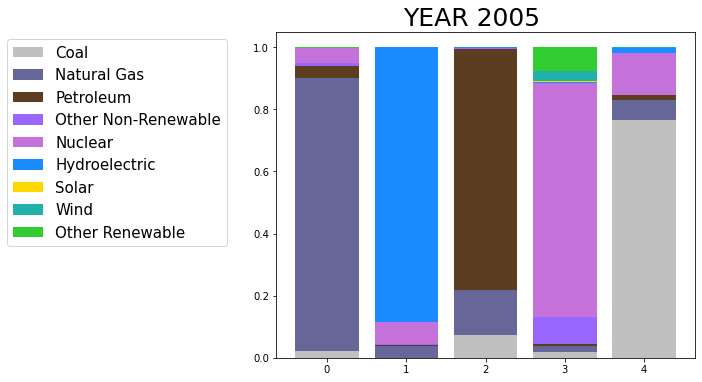

In [88]:
# apply clustering to the operators based on their fuel-type profiles
rr = KMeans(n_clusters=5, random_state = 0).fit(norm2005oper)
rr.labels_ = rr.predict(norm2005oper)
norm2005oper['label'] = list(rr.labels_)
norm2005oper['label'] = norm2005oper['label'].astype(str)

# characterize each cluster by its aggregated fuel-type profile
# normalize by total cluster activity
oper2005['label'] = norm2005oper['label']
clusterChar = oper2005.groupby(['label']).sum().reset_index()
clusterChar = clusterChar[fuel].div(clusterChar[fuel].sum(axis=1), axis=0)
clusterChar = clusterChar[fuel1]

# visualize the clustering together with the categorical fuel-type profile of each cluster
fig,ax = plt.subplots(figsize=(5,5))
ax.set_title('YEAR 2005',fontsize=25)
ax.axis('off')
ins = ax.inset_axes([-.2,-.2,1.5,1.2])
ins.set_prop_cycle(color=['#C0C0C0','#666699','#5c3d1f','#9966ff','#c571da','#1a8cff','#FFD700','#20B2AA','#32CD32'])
bot = np.zeros(5)

for col in clusterChar.columns:
    values = clusterChar[col].values
    ins.bar([0,1,2,3,4], values, bottom = bot, label=col)
    bot = bot + values
    
ins.set_xticks([0,1,2,3,4])    
ins.legend(bbox_to_anchor=(-.1,1),fontsize=15) 

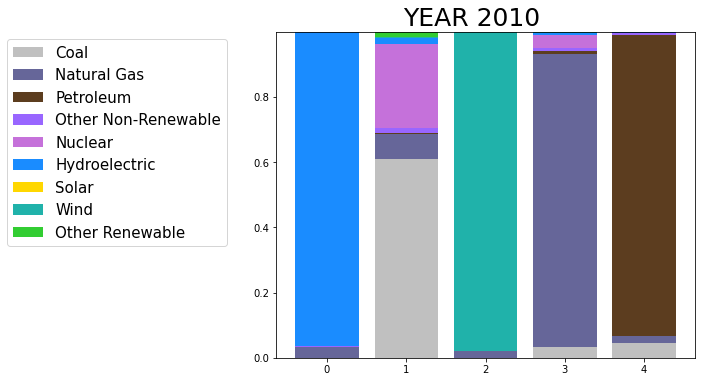

In [89]:
# apply clustering to the operators based on their fuel-type profiles
rr = KMeans(n_clusters=5, random_state = 0).fit(norm2010oper)
rr.labels_ = rr.predict(norm2010oper)
norm2010oper['label'] = list(rr.labels_)
norm2010oper['label'] = norm2010oper['label'].astype(str)

# characterize each cluster by its aggregated fuel-type profile
# normalize by total cluster activity
oper2010['label'] = norm2010oper['label']
clusterChar = oper2010.groupby(['label']).sum().reset_index()
clusterChar = clusterChar[fuel].div(clusterChar[fuel].sum(axis=1), axis=0)
clusterChar = clusterChar[fuel1]

# visualize the clustering together with the categorical fuel-type profile of each cluster
fig,ax = plt.subplots(figsize=(5,5))
ax.set_title('YEAR 2010',fontsize=25)
ax.axis('off')

ins = ax.inset_axes([-.2,-.2,1.5,1.2])
ins.set_prop_cycle(color=['#C0C0C0','#666699','#5c3d1f','#9966ff','#c571da','#1a8cff','#FFD700','#20B2AA','#32CD32'])
bot = np.zeros(5)

for col in clusterChar.columns:
    values = clusterChar[col].values
    ins.bar([0,1,2,3,4], values, bottom = bot, label=col)
    bot = bot + values
    
ins.set_xticks([0,1,2,3,4])    
ins.legend(bbox_to_anchor=(-.1,1),fontsize=15) 

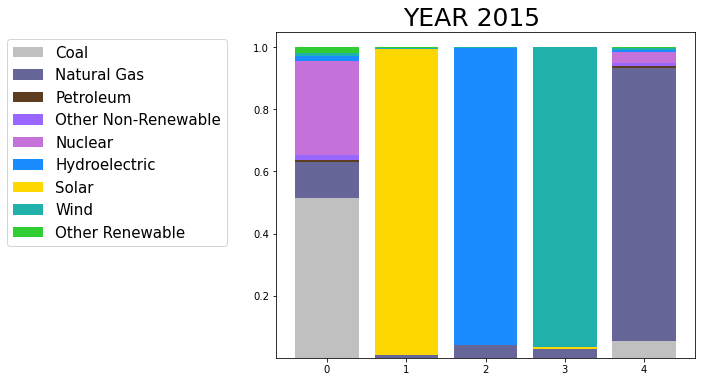

In [90]:
# apply clustering to the operators based on their fuel-type profiles
rr = KMeans(n_clusters=5, random_state = 0).fit(norm2015oper)
rr.labels_ = rr.predict(norm2015oper)
norm2015oper['label'] = list(rr.labels_)
norm2015oper['label'] = norm2015oper['label'].astype(str)

# characterize each cluster by its aggregated fuel-type profile
# normalize by total cluster activity
oper2015['label'] = norm2015oper['label']
clusterChar = oper2015.groupby(['label']).sum().reset_index()
clusterChar = clusterChar[fuel].div(clusterChar[fuel].sum(axis=1), axis=0)
clusterChar = clusterChar[fuel1]

# visualize the clustering together with the categorical fuel-type profile of each cluster
fig,ax = plt.subplots(figsize=(5,5))
ax.set_title('YEAR 2015',fontsize=25)
ax.axis('off')

ins = ax.inset_axes([-.2,-.2,1.5,1.2])
ins.set_prop_cycle(color=['#C0C0C0','#666699','#5c3d1f','#9966ff','#c571da','#1a8cff','#FFD700','#20B2AA','#32CD32'])
bot = np.zeros(5)

for col in clusterChar.columns:
    values = clusterChar[col].values
    ins.bar([0,1,2,3,4], values, bottom = bot, label=col)
    bot = bot + values
    
ins.set_xticks([0,1,2,3,4])    
ins.legend(bbox_to_anchor=(-.1,1),fontsize=15) 

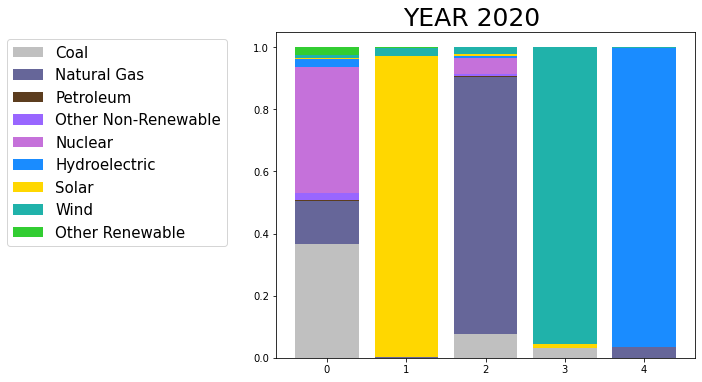

In [91]:
# apply clustering to the operators based on their fuel-type profiles
rr = KMeans(n_clusters=5, random_state = 0).fit(norm2020oper)
rr.labels_ = rr.predict(norm2020oper)
norm2020oper['label'] = list(rr.labels_)
norm2020oper['label'] = norm2020oper['label'].astype(str)

# characterize each cluster by its aggregated fuel-type profile
# normalize by total cluster activity
oper2020['label'] = norm2020oper['label']
clusterChar = oper2020.groupby(['label']).sum().reset_index()
clusterChar = clusterChar[fuel].div(clusterChar[fuel].sum(axis=1), axis=0)
clusterChar = clusterChar[fuel1]

# visualize the clustering together with the categorical fuel-type profile of each cluster
fig,ax = plt.subplots(figsize=(5,5))
ax.set_title('YEAR 2020',fontsize=25)
ax.axis('off')

ins = ax.inset_axes([-.2,-.2,1.5,1.2])
ins.set_prop_cycle(color=['#C0C0C0','#666699','#5c3d1f','#9966ff','#c571da','#1a8cff','#FFD700','#20B2AA','#32CD32'])
bot = np.zeros(5)

for col in clusterChar.columns:
    values = clusterChar[col].values
    ins.bar([0,1,2,3,4], values, bottom = bot, label=col)
    bot = bot + values
    
ins.set_xticks([0,1,2,3,4])    
ins.legend(bbox_to_anchor=(-.1,1),fontsize=15) 

For 2020, the clustering mostly focused on a single fuel source as shown above, but those sources are now almost all renewable (a stark difference from 2005). Based on this analysis, the companies clustered in labels ‘0’ and ‘2’ should shift from non-renewable to renewable energy sources in order to meet Biden’s 2030 goal.
